# Trabajo Práctico 3 - CV: Detectando barcos en el agua

### Importamos las librerías necesarias

In [1]:
from PIL import Image, ImageDraw
import numpy as np
import os
import pandas as pd
import copy as copy
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Activation
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
import keras.callbacks
from keras import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Definimos constantes y funciones auxiliares

In [2]:
#Definimos las constantes para trabajar con las imágenes
PATH = 'imagenes_tp3_cv'
n_colors = 3 # canal de color (RGB), profundidad de la imagen
weight = 80
height = 80

"""Constante para testear las imagenes (ruta local donde tengo almacenadas las imagenes). 
Cambiar en cada caso para que funcione"""

TEST_PATH_PARTIAL = "/home/lucas/analisis_exploratorio/imagenes_tp3_cv/"

In [3]:
"""Función que dada una ruta, retorna un array de imaáenes en formato 'dnumpy' y un array de las etiquetas de cada imagen
(0: no contiene barco; 1: contiene barco)"""

def get_images_and_labels_from_path(path):
    images = []
    labels = []
    for filename in os.listdir(path):        
        img = Image.open(os.path.join(path,filename))
        #yield img
        img_np = np.asarray(img)
        images.append(img_np)
        labels.append(int(filename[0]))
    return images, labels

## Lectura de datos

Se obtienen 2 arrays para el conjunto de datos: 
- images: es un array de numpy con la representación de cada imagen
- labels: es un array con las etiquetas que indican si hay o no barco, correspondiente a cada imagen

In [4]:
images, labels = get_images_and_labels_from_path(PATH)

### Visualizamos algunas de las imágenes del dataset

In [5]:
#Mapeamos los labels con las etiquetas de salida.
classes = {0: 'Not a ship',
           1: 'Ship'}

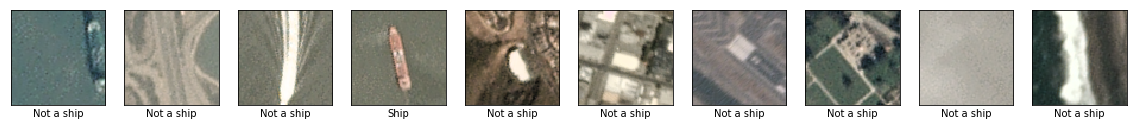

In [6]:
#Visualizamos imagenes con etiquetas.
plt.figure(figsize=(20,10))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    imagen = copy.copy(images[i])
    plt.imshow(imagen.reshape(80, 80, 3), cmap=plt.cm.binary)
    plt.xlabel(classes[labels[i]])

### Pre-procesado de los datos para la CNN

In [7]:
#Separamos el conjunto de datos en train y test
train_images,test_images,train_labels,test_labels = train_test_split(images,labels,test_size=0.2)

In [8]:
#Damos formato a los conjuntos para que sean comprensibles por la CNN
train_images = np.array(train_images).astype('uint8')
train_labels = np.array(train_labels).astype('uint8')

test_images = np.array(test_images).astype('uint8')
test_labels = np.array(test_labels).astype('uint8')

In [9]:
#Validamos la forma de cada conjunto
print('Training data shape : ', train_images.shape, train_labels.shape)
print('Testing data shape : ', test_images.shape, test_labels.shape)

Training data shape :  (3200, 80, 80, 3) (3200,)
Testing data shape :  (800, 80, 80, 3) (800,)


In [10]:
#Damos el formato necesario a cada conjunto para que sean comprensibles por la CNN
X_train = train_images.reshape([-1, n_colors, weight, height])
X_test = test_images.reshape([-1, n_colors, weight, height])

In [11]:
"""Damos el formato necesario a las salidas (target) para que sean comprensibles para la CNN 
cuando utilizamos la función Softmax y 2 neuronas de salida"""

#No se usan con sigmoide (se usan con softmax y 2 neuronas de salida)
#y_train = np_utils.to_categorical(train_labels, 2) 
#y_test = np_utils.to_categorical(test_labels, 2)

'Damos el formato necesario a las salidas (target) para que sean comprensibles para la CNN \ncuando utilizamos la función Softmax y 2 neuronas de salida'

In [12]:
#Mezclamos los indices para el conjunto de train
indexes = np.arange(3200)
np.random.shuffle(indexes)

In [13]:
#Damos el formato necesario a los conjuntos de train para que sean comprensibles con la CNN
X_train = X_train[indexes].transpose([0,2,3,1])
#y_train = y_train[indexes] #No se usa con Sigmoide

#Se usa con Sigmoide
y_train = train_labels 
y_test = test_labels
y_train = y_train[indexes]

In [14]:
# Mezclamos los indices para el conjunto de test
indexes = np.arange(800)
np.random.shuffle(indexes)

In [15]:
#Damos el formato necesario a los conjuntos de test para que sean comprensibles con la CNN

X_test= X_test[indexes].transpose([0,2,3,1])
y_test = y_test[indexes]

In [16]:
"""Transformamos los valores numericos correspondientes a cada color de valores entre 0 y 255, a valores entre 0 y 1,
# para que puedan ser procesados de mejor manera por la CNN"""

X_train = X_train / 255
X_test = X_test / 255

In [17]:
np.random.seed(42)

### Función para evaluar los modelos

In [18]:
def evaluate_model(model, is_cnn):
    #Preparamos los datos y las predicciones según el modelo
    if is_cnn:
            outputs_train = y_train
            predictions_train = cnn_model.predict(X_train)
            outputs_test = y_test
            predictions_test = cnn_model.predict(X_test)
    else:
        inputs_train = extract_inputs(train)
        outputs_train = extract_outputs(train)
        predictions_train = mlp_model.predict(inputs_train)
        inputs_test = extract_inputs(test)
        outputs_test = extract_outputs(test)
        predictions_test = mlp_model.predict(inputs_test)
    
    #Redondeamos los resultados para poder utilizar la matriz de confusión
    outputs_train = np.around(outputs_train)
    predictions_train = np.around(predictions_train)
    outputs_test = np.around(outputs_test)
    predictions_test = np.around(predictions_test)
    
    #Armamos el set para iterar y graficar
    sets = [('train', [outputs_train, predictions_train]), ('test', [outputs_test, predictions_test])]
    
    for set_name, set_data in sets:
        outputs = set_data[0]
        predictions = set_data[1]        
        print(set_name, '#' * 80)      
        
        # Mostramos las métricas      
        print('Accuracy:', accuracy_score(outputs, predictions))
        print('Precision:', precision_score(outputs, predictions))
        print('Recall:', recall_score(outputs, predictions))
        print()
        
        # Dibujamos la matriz de confusión
        plt.figure(figsize=(3,4))

        plt.xticks([0, 1], ['No hay barco', 'Hay barco'], rotation=45)
        plt.yticks([0, 1], ['No hay barco', 'Hay barco'])
        plt.xlabel('Clase predicha')
        plt.ylabel('Clase verdadera')

        plt.title("Test")

        plt.imshow(
            confusion_matrix(outputs, predictions), #Outputs, Predictions
            cmap=plt.cm.Blues, 
            interpolation='nearest',
        )

        plt.show()

## Convolutional Neural Network

In [19]:
#Definición de la arquitectura de la red convolucional
cnn_model = Sequential()

cnn_model.add(Conv2D(32, (3, 3), padding='same', input_shape=(80, 80, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) #40x40
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) #20x20
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) #10x10
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(32, (10, 10), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) #5x5
cnn_model.add(Dropout(0.25))

cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dropout(0.5))

#cnn_model.add(Dense(2, activation='softmax'))

cnn_model.add(Dense(1, activation='sigmoid')) #Probar

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
#Configuración de optimización

#Para softmax
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
#cnn_model.compile(
#    loss='categorical_crossentropy', #Pasar a binary_crossentropy si llego a probar con sigmoid
#    optimizer=sgd,
#    metrics=['accuracy'])

#Para sigmoide
cnn_model.compile(
    optimizer=sgd,
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

#Entrenamiento del modelo
history_cnn = cnn_model.fit(
    X_train, 
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(
        X_test,
        y_test,
    )
)

Instructions for updating:
Use tf.cast instead.
Train on 3200 samples, validate on 800 samples
Epoch 1/100
3200/3200 [==============================] - 34s 11ms/step - loss: 0.5619 - acc: 0.7397 - val_loss: 0.4939 - val_acc: 0.7738
Epoch 2/100
3200/3200 [==============================] - 33s 10ms/step - loss: 0.5292 - acc: 0.7581 - val_loss: 0.5411 - val_acc: 0.7738
Epoch 3/100
3200/3200 [==============================] - 34s 10ms/step - loss: 0.4351 - acc: 0.8119 - val_loss: 0.3155 - val_acc: 0.8712
Epoch 4/100
3200/3200 [==============================] - 37s 11ms/step - loss: 0.4498 - acc: 0.8166 - val_loss: 0.3642 - val_acc: 0.8600
Epoch 5/100
3200/3200 [==============================] - 34s 11ms/step - loss: 0.3469 - acc: 0.8519 - val_loss: 0.2768 - val_acc: 0.8788
Epoch 6/100
3200/3200 [==============================] - 34s 11ms/step - loss: 0.3080 - acc: 0.8697 - val_loss: 0.2566 - val_acc: 0.8875
Epoch 7/100
3200/3200 [==============================] - 34s 11ms/step - loss: 0.28

3200/3200 [==============================] - 34s 10ms/step - loss: 0.0286 - acc: 0.9891 - val_loss: 0.1079 - val_acc: 0.9688
Epoch 59/100
3200/3200 [==============================] - 34s 10ms/step - loss: 0.0285 - acc: 0.9894 - val_loss: 0.1267 - val_acc: 0.9650
Epoch 60/100
3200/3200 [==============================] - 34s 11ms/step - loss: 0.0397 - acc: 0.9869 - val_loss: 0.0695 - val_acc: 0.9762
Epoch 61/100
3200/3200 [==============================] - 34s 11ms/step - loss: 0.0356 - acc: 0.9862 - val_loss: 0.1001 - val_acc: 0.9750
Epoch 62/100
3200/3200 [==============================] - 33s 10ms/step - loss: 0.0243 - acc: 0.9916 - val_loss: 0.0662 - val_acc: 0.9825
Epoch 63/100
3200/3200 [==============================] - 34s 11ms/step - loss: 0.0316 - acc: 0.9875 - val_loss: 0.0894 - val_acc: 0.9700
Epoch 64/100
3200/3200 [==============================] - 34s 11ms/step - loss: 0.0382 - acc: 0.9881 - val_loss: 0.0757 - val_acc: 0.9712
Epoch 65/100
3200/3200 [=======================

#### Opcional: Almacenar el modelo para no entrenar a futuro / leer el modelo almacenado

In [60]:
#Guardamos el modelo, para no tener que reentrenar

#cnn_model.save('cnn_model.h5')  #Creamos un archivo HDF5 llamado 'cnn_model.h5'
#del cnn_model  # eliminamos el modelo existente

In [22]:
# Leemos el modelo previamente almacenado (en caso de que ya hayamos entrenado la red)
#cnn_model = load_model('cnn_model.h5')

### Curva de aprendizaje: train vs test

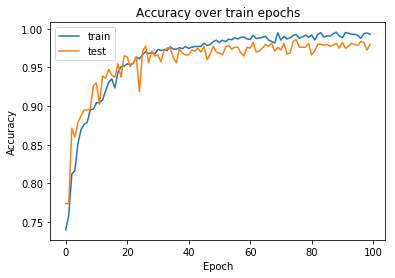

In [23]:
plt.plot(history_cnn.history['acc'], label='train')
plt.plot(history_cnn.history['val_acc'], label='test')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

### Máximo valor de accuracy obtenido durante el entrenamiento

In [57]:
print("Máximo valor de acurracy obtenido en train: " + str(max(history_cnn.history['acc'])))
print("Máximo valor de acurracy obtenido en test: " + str(max(history_cnn.history['val_acc'])))

Máximo valor de acurracy obtenido en train: 0.995625
Máximo valor de acurracy obtenido en test: 0.98625


### Métricas (Matriz de confusión, accuracy, precission y recall):

train ################################################################################
Accuracy: 0.9975
Precision: 0.9951159951159951
Recall: 0.9951159951159951



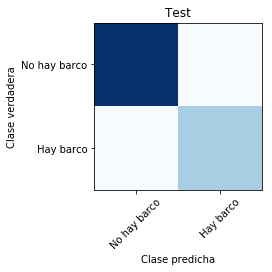

test ################################################################################
Accuracy: 0.98
Precision: 0.927461139896373
Recall: 0.988950276243094



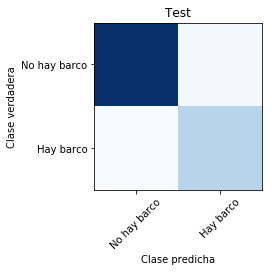

In [25]:
evaluate_model(cnn_model, True)

### Definimos función para testear el modelo CNN

In [26]:
"""Función que dado el nombre de una imagen (de las la ruta 'TEST_PATH_PARTIAL') y el resultado esperado (True o False):
nos muestra la imagen y además un mensaje indicando lo que esperabamos, 
el resultado de la predicción y si acertó o no """

def test_image_cnn(image_name, expected):
    TEST_PATH = TEST_PATH_PARTIAL + image_name  
    
    #Pre-procesamos la imagen
    img = Image.open(TEST_PATH)
    img_np =np.asarray(img)
    img_np = np.array(img_np).astype('uint8')
    X_np = img_np.reshape([-1, n_colors, weight, height])
    X_np = X_np / 255
    X_np = X_np.transpose([0,2,3,1])
    
    #Testeamos la imagen
    result = cnn_model.predict(X_np, batch_size=None, verbose=0, steps=None)
    binary_result = np.around(result)
    ##prob_no = result[0][0] #Cambiar si uso la Sigmoide
    ##prob_si = result[0][1] #Cambiar si uso la Sigmoide
    
    #Mostramos la imagen
    plt.axis('off')
    plt.imshow(img_np)
    plt.title('Imagen: ' + image_name)
    plt.show()
    
    # Imprimimos esperado
    if expected:
        print("Esperado: La imagen contiene un barco.")
    else:
        print("Esperado: La imagen no contiene un barco.")
        
    #Imprimimos la predicción
    if (binary_result[0][0] == 1):        
        print('Predicción: La imagen contiene un barco. Porcentaje de confianza: ' + str(result[0][0] * 100) + '%')
        #Imprimimos la conclusión
        if expected:
            print("Predicción correcta.")
        else:
            print("Predicción incorrecta.")
    else:
        print('Predicción: La imagen no contiene un barco. Porcentaje de confianza: ' + str(100 - (result[0][0] * 100)) + '%')
        #Imprimimos la conclusión
        if not expected:
            print("Predicción correcta.")
        else:
            print("Predicción incorrecta.")
            
    print("")
    print("*" * 100)

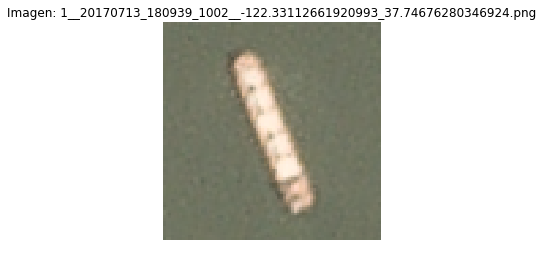

Esperado: La imagen contiene un barco.
Predicción: La imagen contiene un barco. Porcentaje de confianza: 99.9998688697815%
Predicción correcta.

****************************************************************************************************


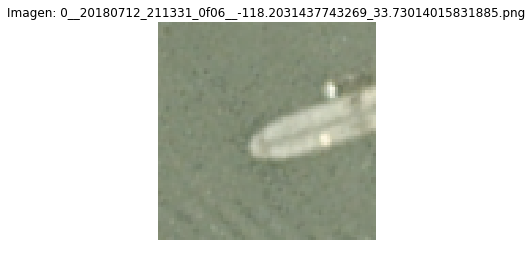

Esperado: La imagen no contiene un barco.
Predicción: La imagen no contiene un barco. Porcentaje de confianza: 99.9979647105647%
Predicción correcta.

****************************************************************************************************


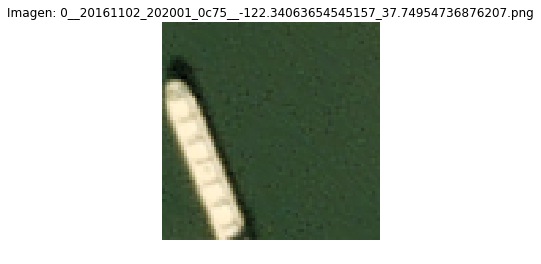

Esperado: La imagen no contiene un barco.
Predicción: La imagen no contiene un barco. Porcentaje de confianza: 99.99999999999997%
Predicción correcta.

****************************************************************************************************


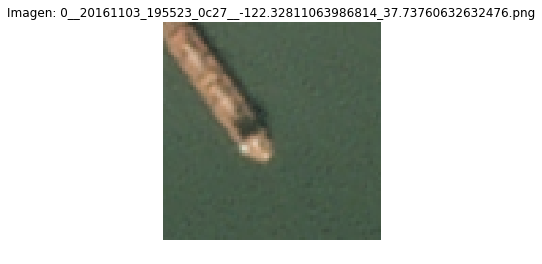

Esperado: La imagen no contiene un barco.
Predicción: La imagen no contiene un barco. Porcentaje de confianza: 99.999999999959%
Predicción correcta.

****************************************************************************************************


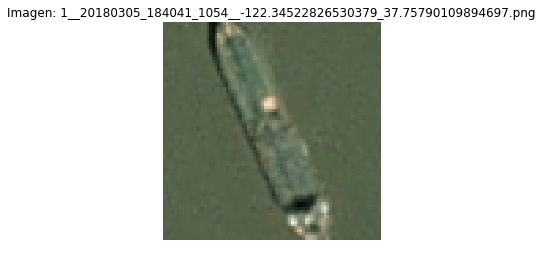

Esperado: La imagen contiene un barco.
Predicción: La imagen contiene un barco. Porcentaje de confianza: 99.9917984008789%
Predicción correcta.

****************************************************************************************************


In [27]:
#Testamos con imágenes
true_image_name = "1__20170713_180939_1002__-122.33112661920993_37.74676280346924.png" 
test_image_cnn(true_image_name, True)

false_image_name = "0__20180712_211331_0f06__-118.2031437743269_33.73014015831885.png" 
test_image_cnn(false_image_name, False)

#test - dificil
false_image_name = "0__20161102_202001_0c75__-122.34063654545157_37.74954736876207.png"
test_image_cnn(false_image_name, False)

false_image_name = "0__20161103_195523_0c27__-122.32811063986814_37.73760632632476.png"
test_image_cnn(false_image_name, False)

true_image_name = "1__20180305_184041_1054__-122.34522826530379_37.75790109894697.png"
test_image_cnn(true_image_name, True)

## Conclusiones Convolutional Neural Network

- Como podemos observar, los resultados obtenidos a partir de las métricas son excelentes. Logrando durante el entrenamiento un accuracy máximo en train de 0.995625 y en test de 0.98625. Y obteniendo en la iteración final (la número 100), un valor de **0.9931 para train y de 0.9800 para test**, para ésta misma métrica. Además si complementamos con otras, podemos ver que siguen manteniendo valores muy altos: por encima de 0.99 para train y por encima de 0.98 en test, a excepción de precission la cual está por encima de 0.92. 

    Al ver estos resultados esperaríamos que el modelo sea capaz de predecir correctamente si hay o no un barco presente en una imagen dada. Para comprobarlo, hicimos lo siguiente: le dimos al modelo 5 imágenes, las cuales fueron pre-procesadas para que las entienda y posteriormente prediga si hay o no un barco. ¡Los resultados fueron excelentes! El modelo fue capaz de predecir las 5 imágenes según lo esperado, incluso en casos dificiles, ¡y con un alto porcentaje de confianza en todos los casos! (por encima del 99%).

    Finalmente podemos concluir que **el modelo es confiable y capaz de predecir correctamente la etiqueta a partir de los ejemplos**, siempre y cuando le demos imagenes similares a las del set de datos de entrenamiento. Es decir si le damos una imagen que contiene un barco, pero el mismo se encuentra cortado, el modelo nos indicará que no hay ningún barco presente, tal y como esperaríamos, ya que en el dataset de entrenamiento cuando un barco no se encontraba completo, la imagen era etiquetada como "sin barco".

***

### Pre-procesado de los datos para la MLP NN

Creamos una lista de imagenes 'flatten' (aplanadas), donde cada fila representa una imagen. Transformamos la estructura
tridimensional de la imagen en una unidimencional, para ello se coloca cada fila de pixeles de manera consecutiva para que constituyan un arreglo de una única dimension. Cada imagen tendrá el siguiente formato: 

[r00, g00, b00, ..., r79, g79, b79]

**Explicación:** Valor del pixel color rojo fila 0 columna 0, seguido del valor del pixel color verde fila 0 columna 0, seguido de valor del pixel axul rojo fila 0 columna 0, ......, Valor del pixel color rojo fila 79 columna 79, seguido del valor del pixel color verde fila 79 columna 79, seguido de valor del pixel axul rojo fila 79 columna 79

Además, creamos una lista con el nombre de las columnas (r00, g00, b00, ..., r79, g79, b79), para armar el dataframe que luego se le dará a las MLP NN

In [28]:
#Creamos la lista de imagenes 'flatten'
flatten_images = []

for i in range(4000):
    imagen = images[i]
    flatten_image = imagen.flatten()
    flatten_image = flatten_image / 255
    flatten_images.append(flatten_image)

#Creamos la lista de nombres de columnas para el dataframe (columna = color+fila+columna)
columnas = []
colores = ['r', 'g', 'b']
for f in range(80):
    for c in range(80):
        for color in colores:
            col_name = str(color + str(f) + str(c))
            columnas.append(col_name)

In [29]:
#Creamos el dataframe a partir de las imagenes 'flatten' y las columnas
df = pd.DataFrame.from_records(flatten_images, columns = columnas)

#Añadimos la columna target (si contiene o no barco) al dataframe 
df["is_ship"] = labels

#### Opcional: almacenamos el dataframe en un csv para no hacer este paso nuevamente. 

**Problema:** al realizar la división por 255, cuando se crea la lista de imagenes flatten, el archivo csv, queda muy grande. Para solucionar esto podemos realizar la división a posteriori y que en el csv solo haya enteros (entre 0 y 255)

In [30]:
#Almacenamos el dataframe en un archivo csv
#df.to_csv('flatten_images.csv') 

#Leemos el archivo csv previamente almacenado
#df = pd.read_csv("flatten_images.csv")

In [31]:
#Eliminamos la columna que se genera al almacenar el dataframe en el archivo csv
#df.drop("Unnamed: 0",axis = 1,inplace = True)

#Visualizamos el dataframe
df.head()

,r00,g00,b00,r01,g01,b01,r02,g02,b02,r03,...,r7977,g7977,b7977,r7978,g7978,b7978,r7979,g7979,b7979,is_ship
0,0.372549,0.458824,0.443137,0.364706,0.450980,0.431373,0.356863,0.447059,0.419608,0.372549,...,0.376471,0.466667,0.458824,0.372549,0.462745,0.458824,0.372549,0.466667,0.458824,0
1,0.588235,0.564706,0.521569,0.513725,0.505882,0.462745,0.490196,0.486275,0.443137,0.533333,...,0.549020,0.533333,0.486275,0.533333,0.525490,0.482353,0.521569,0.513725,0.466667,0
2,0.505882,0.501961,0.431373,0.458824,0.466667,0.392157,0.462745,0.470588,0.400000,0.454902,...,0.478431,0.478431,0.427451,0.494118,0.486275,0.435294,0.486275,0.478431,0.423529,0
3,0.435294,0.443137,0.392157,0.439216,0.450980,0.396078,0.443137,0.454902,0.400000,0.419608,...,0.439216,0.450980,0.388235,0.447059,0.450980,0.392157,0.462745,0.466667,0.411765,1
4,0.560784,0.466667,0.364706,0.517647,0.431373,0.329412,0.462745,0.384314,0.286275,0.490196,...,0.321569,0.282353,0.223529,0.356863,0.309804,0.247059,0.427451,0.368627,0.298039,0


In [32]:
#Separamos el conjunto de datos en: train y test
train, test = train_test_split(df, test_size=0.2)

### Definimos funciones auxiliares y constantes para la MLP NN

In [33]:
#Definimos las columnnas de entrada que tendrá nuestra red
INPUT_COLUMNS = df.columns.values
index_target = np.where(INPUT_COLUMNS == 'is_ship')[0]
INPUT_COLUMNS = np.delete(INPUT_COLUMNS,index_target[0])

In [34]:
#Definimos las funciones para obtener las inputs y los outputs

def extract_inputs(data):
    return data.iloc[:, 0:19200].values
    #return data[INPUT_COLUMNS].values #Error: retorna 22140 elementos en lugar de 19200

def extract_outputs(data):     
    #return np_utils.to_categorical(data['is_ship'].values, 2)
    return data['is_ship'].values

## MLP Neural Network

In [35]:
# Definición de la arquitectura de la red MLP
mlp_model = Sequential([   
    Dense(1000, input_shape=(len(INPUT_COLUMNS), )),
    Activation('relu'),
    Dense(500),
    Activation('relu'),
    Dropout(0.10),
    Dense(250),
    Activation('relu'),
    Dropout(0.10),
    Dense(125),
    Activation('relu'),
    Dropout(0.10),
    Dense(60),
    Activation('relu'),
    Dropout(0.10),
    Dense(30),
    Activation('relu'),
    Dropout(0.10),
    #Dense(2),
    #Activation('softmax'),
    Dense(1),
    Activation('sigmoid'),
])

mlp_model.compile(
    optimizer='adam',
    #loss='categorical_crossentropy',
    loss='binary_crossentropy',
    metrics=['accuracy',],
)

In [46]:
#Entrenamos la red neuronal
history_mlp = mlp_model.fit(
    extract_inputs(train), 
    extract_outputs(train), 
    epochs=100,
    batch_size=128,
    validation_data=(
        extract_inputs(test),
        extract_outputs(test),
    )
)

Train on 3200 samples, validate on 800 samples
Epoch 1/100
3200/3200 [==============================] - 13s 4ms/step - loss: 0.1630 - acc: 0.9344 - val_loss: 0.1807 - val_acc: 0.9213
Epoch 2/100
3200/3200 [==============================] - 13s 4ms/step - loss: 0.1354 - acc: 0.9491 - val_loss: 0.2194 - val_acc: 0.9250
Epoch 3/100
3200/3200 [==============================] - 13s 4ms/step - loss: 0.1010 - acc: 0.9609 - val_loss: 0.1708 - val_acc: 0.9375
Epoch 4/100
3200/3200 [==============================] - 13s 4ms/step - loss: 0.0747 - acc: 0.9691 - val_loss: 0.1825 - val_acc: 0.9375
Epoch 5/100
3200/3200 [==============================] - 13s 4ms/step - loss: 0.1056 - acc: 0.9594 - val_loss: 0.1535 - val_acc: 0.9413
Epoch 6/100
3200/3200 [==============================] - 13s 4ms/step - loss: 0.0739 - acc: 0.9694 - val_loss: 0.2018 - val_acc: 0.9300
Epoch 7/100
3200/3200 [==============================] - 13s 4ms/step - loss: 0.0723 - acc: 0.9744 - val_loss: 0.2209 - val_acc: 0.9375
E

#### Opcional: Almacenar el modelo para no entrenar a futuro / leer el modelo almacenado

In [61]:
#Guardamos el modelo, para no tener que reentrenar

#mlp_model.save('mlp_model.h5')  #  creamos un archivo HDF5 llamado 'mlp_model.h5'
# del mlp_model  # eliminamos el modelo existente

In [38]:
#Leemos el modelo previamente almacenado (en caso de que ya hayamos entrenado la red)
#mlp_model = load_model('mlp_model.h5')

### Curva de aprendizaje: train vs test

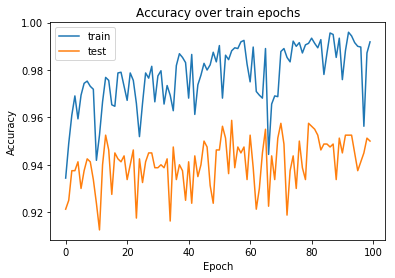

In [47]:
plt.plot(history_mlp.history['acc'], label='train')
plt.plot(history_mlp.history['val_acc'], label='test')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

### Máximo valor de accuracy obtenido durante el entrenamiento

In [58]:
print("Máximo valor de acurracy obtenido en train: " + str(max(history_mlp.history['acc'])))
print("Máximo valor de acurracy obtenido en test: " + str(max(history_mlp.history['val_acc'])))

Máximo valor de acurracy obtenido en train: 0.9959375
Máximo valor de acurracy obtenido en test: 0.95875


### Métricas (Matriz de confusión, accuracy, precission y recall):

train ################################################################################
Accuracy: 0.9971875
Precision: 0.9949494949494949
Recall: 0.9936948297604036



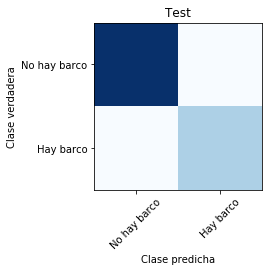

test ################################################################################
Accuracy: 0.95
Precision: 0.8847926267281107
Recall: 0.927536231884058



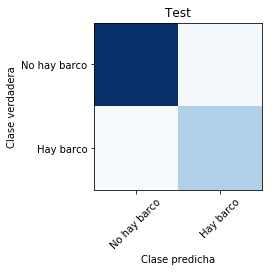

In [49]:
evaluate_model(mlp_model, False)

### Definimos función para testear el modelo MLP

In [50]:
"""Función que dado el nombre de una imagen (de las la ruta 'TEST_PATH_PARTIAL') y el resultado esperado (True o False): 
nos muestra la imagen y además un mensaje indicando lo que esperabamos, 
el resultado de la predicción y si acertó o no"""

flatten_images_test = []
def test_image_mlp(image_name, expected):
    TEST_PATH = TEST_PATH_PARTIAL + image_name  
    
    #Pre-procesamos la imagen
    img = Image.open(TEST_PATH)
    img_np =np.asarray(img)
    flatten_image = img_np.flatten()
    flatten_image = flatten_image / 255
    flatten_images_test.append(flatten_image)
    df_test = pd.DataFrame.from_records(flatten_images_test, columns = columnas)
    input_model = df_test.iloc[:, 0:19200].values
    
    #Testeamos la imagen
    result = mlp_model.predict(input_model, batch_size=None, verbose=0, steps=None)       
    binary_result = np.around(result)
    ##prob_no = result[0][0] #Cambiar si uso la Sigmoide
    ##prob_si = result[0][1] #Cambiar si uso la Sigmoide
    
    #Mostramos la imagen
    plt.axis('off')
    plt.imshow(img_np)
    plt.title('Imagen: ' + image_name)
    plt.show()
    
    # Imprimimos esperado
    if expected:
        print("Esperado: La imagen contiene un barco.")
    else:
        print("Esperado: La imagen no contiene un barco.")
        
    #Imprimimos la predicción
    if (binary_result[0][0] == 1):        
        print('Predicción: La imagen contiene un barco. Porcentaje de confianza: ' + str(result[0][0] * 100) + '%')
        #Imprimimos la conclusión
        if expected:
            print("Predicción correcta.")
        else:
            print("Predicción incorrecta.")
    else:
        print('Predicción: La imagen no contiene un barco. Porcentaje de confianza: ' + str(100 - (result[0][0] * 100)) + '%')
        #Imprimimos la conclusión
        if not expected:
            print("Predicción correcta.")
        else:
            print("Predicción incorrecta.")
            
    print("")
    print("*" * 100)

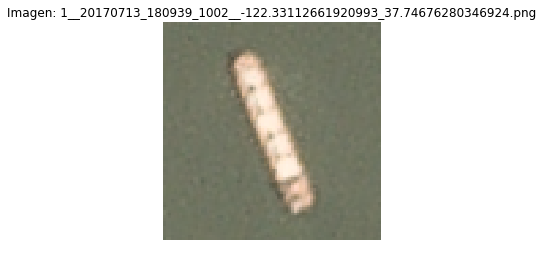

Esperado: La imagen contiene un barco.
Predicción: La imagen contiene un barco. Porcentaje de confianza: 99.99995231628418%
Predicción correcta.

****************************************************************************************************


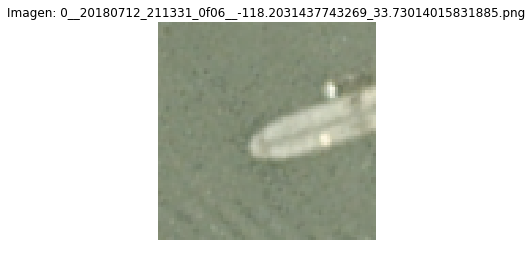

Esperado: La imagen no contiene un barco.
Predicción: La imagen contiene un barco. Porcentaje de confianza: 99.99995231628418%
Predicción incorrecta.

****************************************************************************************************


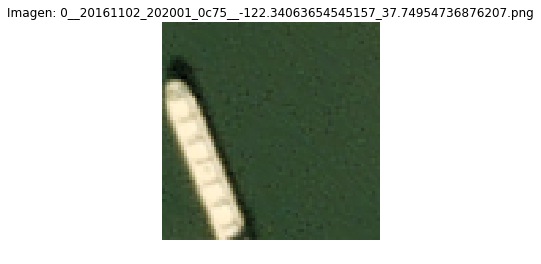

Esperado: La imagen no contiene un barco.
Predicción: La imagen contiene un barco. Porcentaje de confianza: 99.99995231628418%
Predicción incorrecta.

****************************************************************************************************


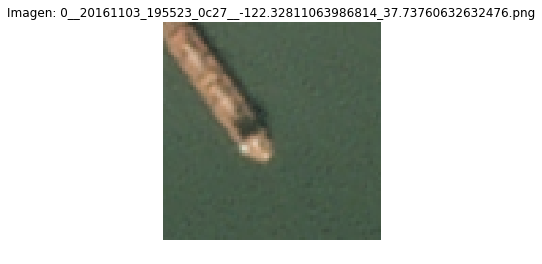

Esperado: La imagen no contiene un barco.
Predicción: La imagen contiene un barco. Porcentaje de confianza: 99.99995231628418%
Predicción incorrecta.

****************************************************************************************************


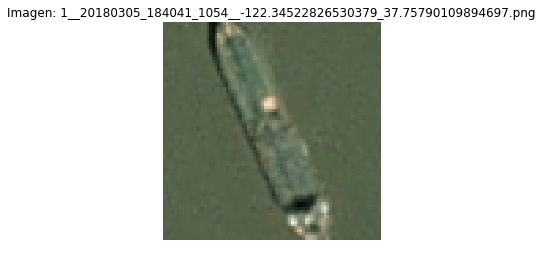

Esperado: La imagen contiene un barco.
Predicción: La imagen contiene un barco. Porcentaje de confianza: 99.99995231628418%
Predicción correcta.

****************************************************************************************************


In [51]:
#Testeo con imágenes
true_image_name = "1__20170713_180939_1002__-122.33112661920993_37.74676280346924.png" 
test_image_mlp(true_image_name, True) 

false_image_name = "0__20180712_211331_0f06__-118.2031437743269_33.73014015831885.png" 
test_image_mlp(false_image_name, False)

#test - dificil
false_image_name = "0__20161102_202001_0c75__-122.34063654545157_37.74954736876207.png" 
test_image_mlp(false_image_name, False)

false_image_name = "0__20161103_195523_0c27__-122.32811063986814_37.73760632632476.png"
test_image_mlp(false_image_name, False)

true_image_name = "1__20180305_184041_1054__-122.34522826530379_37.75790109894697.png"
test_image_mlp(true_image_name, True)

## Conclusiones Multilayer Perceptron Neural Network

- Sorprendentemente los resultados obtenidos en la métrica accuracy son excelentes. Logrando durante el entrenamiento un máximo en train de 0.9959375 y en test de 0.95875. Y obteniendo en la iteración final (la número 100), un valor de **0.9919 para train y de 0.9500 para test**, para ésta misma métrica. Sin embargo, si observamos otra métrica, como por ejemplo la curva de aprendizaje, podemos ver que la misma presenta ciertas irregularidaes: constantemente muestra picos, sin lograr estabilizarse en ningún momento a lo largo de todo el entrenamiento. Además, podemos ver que las métricas obtenidas con el conjunto de train son excelentes: por encima del 0.99, pero no accurre lo mismo con los resultados de las métrcias utilizando el conjunto de test, los cuales si bien son buenos, no son tan sorprendentes como los anteriores, con valores que oscilan entre el 0.88 y el 0.95.

    Al ver estos resultados esperaríamos que el modelo sea capaz de predecir correctamente si hay o no un barco presente en una imagen dada. Para comprobarlo, hicimos lo mismo que con la CNN: le dimos al modelo 5 imágenes, las cuales fueron pre-procesadas para que las entienda y posteriormente prediga si hay o no un barco. Sin embargo, en este caso **los resultados no fueron tan buenos como los vistos en la CNN**. Esta vez, el modelo fue capaz de predecir correctamente los casos en los cuales había barcos, sin embargos falló en aquellos en los que no había barcos (o sí los había pero no completos).

    A la vista de estos resultados, podemos concluir que **el modelo no es confiable y capaz de predecir correctamente la etiqueta a partir de los ejemplos**. Pese a que las métricas obtenidas nos indicarían que el modelo es completamente válido para desempeñar la tarea en cuestión, nuestra prueba con imágenes reales nos demostraron que no es así, ya que el modelo falló en 3 de 5 pruebas con imagenes extraidas del dataset.

## Conclusiones finales

- Podemos concluir que el modelo indicado para resolver el problema de nuestro caso de estudio, fue una **red neuronal convolucional**. Si bien, la red neuronal MLP que construimos, obtuvo muy buenos resultados en las métricas, en la práctica observamos que no funcionó correctamente. Sin embargo éste es el resultado que esperábamos poder demostrar. 

    En un comparativo entre estos dos tipos de redes, podemos decir que las convolucionales se comportan mejor para este tipo de tareas (clasificación de imágenes). En la CNN que construimos, los valores de las métricas fueron capaces de sorprendernos (alcanzaron puntajes muy altos), además tales valores se correspondieron perfectamente con los obtenidos en los casos prácticos, lo cual no ocurrió con la MLP que construimos. Y es éste último punto el que nos hizo llegar a la conclusión planteada.